# PatternMatcher

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

## Load CNN model for classfying anomaly patterns

In [3]:
import sys
sys.path.append("../")
from diagnoser.cnn_model import CNN1d, CLASS_TO_CATEGORY_WITHOUT_AP, TYPE0_CLASSES_WITHOUT_AP, TYPE1_CLASSES_WITHOUT_AP, TYPE2_CLASSES_WITHOUT_AP, NORMAL_CLASSES_WITHOUT_AP, ANONALY_CLASSES_WITHOUT_AP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

model = CNN1d(num_classes=len(CLASS_TO_CATEGORY_WITHOUT_AP))
model.load_state_dict(torch.load("models/current_best_cnn1d_without_ap.pth"))
model.eval()
torchinfo.summary(model, input_size=(1, 1, 180))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [1, 15]                   --
├─Conv1d: 1-1                            [1, 64, 177]              320
├─Conv1d: 1-2                            [1, 128, 84]              32,896
├─Conv1d: 1-3                            [1, 256, 38]              131,328
├─Dropout: 1-4                           [1, 4608]                 --
├─Linear: 1-5                            [1, 64]                   294,976
├─BatchNorm1d: 1-6                       [1, 64]                   128
├─Dropout: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 15]                   975
Total params: 460,623
Trainable params: 460,623
Non-trainable params: 0
Total mult-adds (M): 8.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.84
Estimated Total Size (MB): 2.10

## Load datasets

In [4]:
from meltria.loader import DatasetRecord

def get_well_injected_fault_dataset(_datasets) -> list[tuple[DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
    well_injected_fault_dataset_entries_texts: list[str] = """
carts/pod-cpu-hog/0
carts-db/pod-memory-hog/0
payment/pod-cpu-hog/0
user/pod-cpu-hog/0
catalogue-db/pod-memory-hog/0
catalogue/pod-cpu-hog/0
orders/pod-network-loss/0
orders/pod-cpu-hog/0
catalogue-db/pod-cpu-hog/0
user-db/pod-memory-hog/0
orders/pod-memory-hog/0
carts-db/pod-cpu-hog/0
orders-db/pod-cpu-hog/0
orders-db/pod-network-loss/0
orders-db/pod-memory-hog/0
user/pod-network-loss/0
payment/pod-network-loss/0
catalogue/pod-network-loss/0
catalogue-db/pod-network-loss/0
payment/pod-memory-hog/0
front-end/pod-memory-hog/0
user/pod-memory-hog/0
user-db/pod-cpu-hog/0
catalogue/pod-memory-hog/0
carts/pod-network-loss/0
front-end/pod-cpu-hog/0
carts-db/pod-network-loss/0
carts/pod-memory-hog/0
user-db/pod-network-loss/0
    """.splitlines()
    well_injected_fault_dataset_entries: list[tuple[str, str]] = [
        tuple(line.rstrip("/0").split("/")) for line in well_injected_fault_dataset_entries_texts
    ][1:]

    well_injected_fault_datasets = [
        (record, filtered_df, anomalous_df, reduced_df) 
        for record, filtered_df, anomalous_df, reduced_df in _datasets 
        if (record.chaos_comp(), record.chaos_type()) in well_injected_fault_dataset_entries
    ]
    return well_injected_fault_datasets

In [82]:
## Load data
from notebooklib.save import load_tsdr

DATASET_ID = "qknmc"  # sockshop
datasets = get_well_injected_fault_dataset(load_tsdr(DATASET_ID, revert_normalized_time_series=True))
assert len(datasets) != 0

## Predicting anomaly pattern with the CNN model

In [83]:
from torch.utils.data import Dataset
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore

import sys
sys.path.append("../")
from meltria import loader

NUM_METRICS_PER_BATCH = 100

class TSDataset(Dataset):
    def __init__(self, metrics_df: pd.DataFrame, class_to_category: dict[int, str]):
        super(TSDataset, self).__init__()
        self.metrics_df = metrics_df
        self.time_series = torch.tensor([
            self.metrics_df.loc[:, "time_series"].apply(lambda x: minmax_scale(x, feature_range=(0, 1))),
        ], dtype=torch.float32)  # use float64 to avoid error
        self.class_to_category = class_to_category

    def __getitem__(self, idx):
        return self.time_series[:, idx]

    def __len__(self):
        return len(self.metrics_df)

    def number_of_class(self) -> int:
        return len(self.class_to_category.keys())
    
    def categories(self) -> set[str]:
        return set(self.class_to_category.values())

def transform_to_testset(datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]], record_target_idx: int) -> pd.DataFrame:
    items: list[dict] = []
    for dataset in datasets:
        record = dataset[0]
        data_df: pd.DataFrame = dataset[1 + record_target_idx]
        for col, ts in data_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

def predict_anomaly_categories(
    records: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    nn_model: CNN1d,
    record_target_idx: int = 0,
) -> pd.DataFrame:
    nn_model.eval()
    metrics_df: pd.DataFrame = transform_to_testset(records, record_target_idx)
    dataset = TSDataset(metrics_df, class_to_category=CLASS_TO_CATEGORY_WITHOUT_AP)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True, shuffle=False)
    results: list[tuple[str, str, str, str, str, float]] = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            output, proba = nn_model(data)
            pred = output.argmax(dim=1, keepdim=True)
            pred_proba = proba.max(dim=1, keepdim=True).values
            for _pred, _pred_proba in zip(pred, pred_proba):
                pred_class = _pred.item()
                pred_anomaly_type: str
                match pred_class:
                    case pred_class if pred_class in TYPE0_CLASSES_WITHOUT_AP:
                        pred_anomaly_type = "type0"
                    case pred_class if pred_class in TYPE1_CLASSES_WITHOUT_AP:
                        pred_anomaly_type = "type1"
                    case pred_class if pred_class in TYPE2_CLASSES_WITHOUT_AP:
                        pred_anomaly_type = "type2"
                    case _:
                        assert False, f"Unknown class: {pred_class}"
                pred_binary_category = "normal" if pred_class in NORMAL_CLASSES_WITHOUT_AP else "anomaly"
                pred_category = dataset.class_to_category[pred_class]
                if "/" in pred_category:
                    pred_anomaly_pattern, pred_anomaly_position = pred_category.split("/")
                else:
                    pred_anomaly_pattern, pred_anomaly_position = pred_category, ""
                results.append((pred_category, pred_binary_category, pred_anomaly_type, pred_anomaly_pattern, pred_anomaly_position, _pred_proba.item()))
    return metrics_df.join(pd.DataFrame(results, columns=["anomaly_raw_category", "anomaly_binary_category", "anomaly_type", "anomaly_pattern", "anomaly_position", "probability"]))

In [84]:
predicted_df = predict_anomaly_categories(datasets, model)

In [85]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(predicted_df.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp", "anomaly_pattern", "anomaly_position"]).size())

dataset_id  target_app  chaos_type        chaos_comp    anomaly_pattern             anomaly_position
qknmc       sock-shop   pod-cpu-hog       carts         Fluctuations                                     55
                                                        Level shift down                                355
                                                        Level shift up                                  207
                                                        Multiple dips                                    30
                                                        Multiple spikes                                 121
                                                        Other normal                                    162
                                                        Single dip                                       93
                                                        Single spike                                    360
                                   

## Calculating anomaly degree on phase1 in post

In [86]:
import scipy.stats

from tsdr import unireducer

## KS test
FAILURE_DETECT_IDX = 180 - 60//15 * 5 - 1 # 180 datapoints (45min), 15sec interval scraping and 5min chaos

def ks_test(x) -> float:
    ts = np.array(x.time_series)
    train_x, test_x = np.split(ts, [FAILURE_DETECT_IDX - 60//15 * 30])
    pval = scipy.stats.ks_2samp(train_x, test_x).pvalue
    return pval

predicted_df["anomaly_degree"] = predicted_df.apply(ks_test, axis=1)

In [87]:
## Drop rows accepted by KS test
predicted_df_after_ks_test = predicted_df[predicted_df["anomaly_degree"] <= 0.05]
predicted_df.shape, predicted_df_after_ks_test.shape

((56482, 13), (20965, 13))

## Scoring root-cause candidate metrics

In [88]:
from sklearn.preprocessing import minmax_scale

MIN_P: float = 0.0001

def rank_score_of_patternmatcher(x: pd.Series) -> np.ndarray:
    pw: float  # weight
    match (at := x["anomaly_type"]):
        case "type1":
            pw = 0.8 
        case "type2":
            pw = 0.2
        case "type0":
            pw = 0.0
        case _:
            assert False, f"Unknown anomaly type: {at}"
    P = x["anomaly_degree"]  # anomaly degree (normalize to [0, 1])
    return (-np.log2(max([P, MIN_P]))) * pw
    # return (-np.log2(P)) * pw

In [89]:
predicted_df_after_ks_test["rank_score"] = predicted_df_after_ks_test.apply(rank_score_of_patternmatcher, axis=1)
predicted_df_after_ks_test.head()

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series,anomaly_raw_category,anomaly_binary_category,anomaly_type,anomaly_pattern,anomaly_position,probability,anomaly_degree,rank_score
2,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_usage_bytes,"[300032000.0, 300032000.0, 300032000.0, 300032...",Level shift up,anomaly,type1,Level shift up,,0.999786,4.537305e-07,10.630170
4,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_rss,"[297775104.0, 297775104.0, 297775104.0, 297775...",Level shift up,anomaly,type1,Level shift up,,0.999825,2.227486e-22,10.630170
8,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_memory_working_set_bytes,"[300032000.0, 300032000.0, 300032000.0, 300032...",Level shift up,anomaly,type1,Level shift up,,0.999786,4.537305e-07,10.630170
12,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_cpu_usage_seconds_total,"[0.0699, 0.0667, 0.0529, 0.0698, 0.0707, 0.053...",Level shift up,anomaly,type1,Level shift up,,0.999597,2.251900e-02,4.378171
13,qknmc,sock-shop,carts,pod-cpu-hog,c-carts_cpu_cfs_periods_total,"[8.7044, 8.0, 5.9818, 7.6667, 8.3198, 7.157, 8...",Multiple dips,anomaly,type2,Multiple dips,,0.381319,2.443819e-05,2.657542


In [90]:
group_keys = ["dataset_id", "target_app", "chaos_type", "chaos_comp"]
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(predicted_df_after_ks_test.query("anomaly_pattern != 'Steady increase' and anomaly_pattern != 'Steady decrease'").sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank_score"], ascending=False).groupby(group_keys).head(n=10).set_index(group_keys))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                        
qknmc      sock-shop  pod-network-loss user-db                          c-catalogue_memory_usage_bytes   
                                       user-db                                  c-catalogue_memory_rss   
                                       user-db                    c-catalogue_memory_working_set_bytes   
                                       user-db                    c-orders-db_blkio_device_usage_total   
                                       user-db                       c-orders-db_fs_writes_bytes_total   
                                       user-db                        c-payment_memory_max_usage_bytes   
                                       user-db                            c-user-db_memory_usage_bytes   
                                       user-db                                       c-user-db_sockets   
                                       user-db                              c-user-db_file_descriptors   
                                       user-db                                       c-user-db_threads   
                                       user                             c-carts_memory_max_usage_bytes   
                                       user                                 c-carts_memory_usage_bytes   
                                       user                                         c-carts_memory_rss   
                                       user                           c-carts_memory_working_set_bytes   
                                       user                                 c-carts-db_fs_writes_total   
                                       user                           c-carts-db_cpu_cfs_periods_total   
                                       user                             c-catalogue_memory_usage_bytes   
                                       user                        c-catalogue_cpu_usage_seconds_total   
                                       user                                     c-catalogue_memory_rss   
                                       user                          c-catalogue_cpu_cfs_periods_total   
                                       payment                        c-carts_memory_working_set_bytes   
                                       payment                              c-carts_memory_usage_bytes   
                                       payment                                      c-carts_memory_rss   
                                       payment                     c-carts-db_memory_working_set_bytes   
                                       payment                    c-catalogue_memory_working_set_bytes   
                                       payment                          c-catalogue_memory_usage_bytes   
                                       payment                    c-catalogue-db_memory_failures_total   
                                       payment                                     c-payment_last_seen   
                                       payment                                   c-shipping_memory_rss   
                                       payment                                       c-user_memory_rss   
                                       orders-db                            c-carts_memory_usage_bytes   
                                       orders-db                        c-carts_memory_max_usage_bytes   
                                       orders-db                      c-carts_memory_working_set_bytes   
                                       orders-db                                    c-carts_memory_rss   
                                       orders-db                  c-orders-db_memory_working_set_bytes   
                                       orders-db                                   c-orders-db_threads   
                                       orders-db                    

### with TSifter

In [102]:
datasets_fluxrank = load_tsdr(DATASET_ID, suffix="fluxrank", revert_normalized_time_series=True)
datasets_hier_sbd = load_tsdr(DATASET_ID, suffix="hier_sbd", revert_normalized_time_series=True)

In [103]:
predicted_and_reduced_df = predict_anomaly_categories(datasets, model, record_target_idx=2)

In [156]:
from tsdr.outlierdetection.residual_integral import residual_integral_max

predicted_and_reduced_df["anomaly_degree"] = predicted_and_reduced_df.apply(lambda x: residual_integral_max(x.time_series, bkp=0)[0], axis=1)

In [158]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def _minmax_scale(X):
    # X_ = np.atleast_2d(X)
    nz = minmax_scale(X, feature_range=(0, 1))
    # reverse nz
    return pd.DataFrame(1-nz, X.index)

grp_predicted_and_reduced_df = predicted_and_reduced_df.groupby(["dataset_id", "target_app", "chaos_type", "chaos_comp"])
predicted_and_reduced_df["anomaly_degree"] = grp_predicted_and_reduced_df["anomaly_degree"].apply(_minmax_scale)

In [159]:
def rank_score_of_patternmatcher_fixed(x: pd.Series) -> np.ndarray:
    pw: float  # weight
    match (at := x["anomaly_type"]):
        case "type1":
            pw = 0.8
        case "type2":
            pw = 0.2
        case "type0":
            pw = 0.0
        case _:
            assert False, f"Unknown anomaly type: {at}"
    P = x["anomaly_degree"]  # anomaly degree (normalize to [0, 1])
    return (-np.log2(max([P, MIN_P]))) * pw

In [160]:
predicted_and_reduced_df["rank_score"] = predicted_and_reduced_df.apply(rank_score_of_patternmatcher_fixed, axis=1)
predicted_and_reduced_df.sample(n=5)

,dataset_id,target_app,chaos_comp,chaos_type,metric,time_series,anomaly_raw_category,anomaly_binary_category,anomaly_type,anomaly_pattern,anomaly_position,probability,anomaly_degree,rank_score
5155,qknmc,sock-shop,catalogue-db,pod-network-loss,m-carts-db_mongodb_ss_wt_lock_txn_global_write...,"[3.2333, 3.2333, 3.2333, 3.2333, 3.2333, 3.283...",Level shift down,anomaly,type1,Level shift down,,0.678994,0.531609,0.729250
4683,qknmc,sock-shop,payment,pod-network-loss,m-user-db_mongodb_ss_tcmalloc_tcmalloc_total_f...,"[4145928.0, 4193944.0, 4189880.0, 4186952.0, 4...",Single dip,anomaly,type2,Single dip,,0.444856,0.765726,0.077020
5724,qknmc,sock-shop,front-end,pod-memory-hog,m-carts-db_mongodb_ss_wt_cache_eviction_walks_...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0667, 0....",Multiple spikes,anomaly,type2,Multiple spikes,,0.616161,0.538058,0.178833
6846,qknmc,sock-shop,carts,pod-network-loss,m-carts-db_mongodb_ss_wt_txn_transaction_check...,"[23.0, 23.0, 23.0, 23.0, 23.0, 20.0, 20.0, 20....",Single spike,anomaly,type2,Single spike,,0.488244,0.755449,0.080919
6979,qknmc,sock-shop,carts,pod-network-loss,m-shipping_Tomcat_RequestProcessor_bytesReceived,"[296.25, 296.25, 296.25, 296.25, 296.25, 294.9...",Level shift down,anomaly,type1,Level shift down,,0.975328,0.365989,1.160102


In [166]:
sorted_results_df = predicted_and_reduced_df.query("not metric.str.startswith('n-')", engine='python').loc[:, predicted_and_reduced_df.columns != "time_series"].dropna(subset=["rank_score"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank_score"], ascending=False).groupby(group_keys)
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
    display(sorted_results_df.head(n=20).set_index(group_keys))

metric  \
dataset_id target_app chaos_type       chaos_comp                                                                                              
qknmc      sock-shop  pod-network-loss user-db                                    m-orders_org_mongodb_driver_ConnectionPool_CheckedOutCount   
                                       user-db                                              m-shipping_Tomcat_RequestProcessor_contentLength   
                                       user-db                   m-orders-db_mongodb_ss_wt_checkpoint_cleanup_pages_skipped_during_tree_walk   
                                       user-db                                            m-orders-db_mongodb_ss_wt_block_manager_bytes_read   
                                       user-db                                                                             s-payment_latency   
                                       user-db                                                     m-front-end_process_resident_memory_bytes   
                                       user-db                                                       m-carts_Tomcat_WebResourceRoot_hitCount   
                                       user-db                                                                     c-user_memory_usage_bytes   
                                       user-db                                            m-carts_Tomcat_GlobalRequestProcessor_requestCount   
                                       user-db                                                            m-user_go_memstats_stack_sys_bytes   
                                       user-db                                                       m-carts_Tomcat_WebModule_processingTime   
                                       user-db                                                 m-shipping_Tomcat_WebResourceRoot_lookupCount   
                                       user-db             m-carts-db_mongodb_ss_wt_cursor_cursor_next_calls_that_skip_less_than_100_entries   
                                       user-db                                                  m-shipping_Tomcat_RequestProcessor_bytesSent   
                                       user-db                                         m-shipping_Tomcat_GlobalRequestProcessor_requestCount   
                                       user-db                                                m-carts-db_mongodb_ss_network_physicalBytesOut   
                                       user-db                                              m-carts-db_mongodb_ss_locks_Mutex_acquireCount_r   
                                       user-db                                                         m-carts-db_mongodb_ss_opLatencies_ops   
                                       user-db                                                m-carts-db_mongodb_ss_wt_log_log_bytes_written   
                                       user-db                                             m-carts-db_mongodb_ss_metrics_commands_find_total   
                                       user                                                           m-carts-db_mongodb_sys_disks_sda_reads   
                                       user                                                          m-orders-db_mongodb_sys_disks_sda_reads   
                                       user                                                              m-orders-db_mongodb_sys_mounts_free   
                                       user                                                               m-carts-db_mongodb_sys_mounts_free   
                                       user                                                                     m-catalogue_process_open_fds   
                                       user                                              m-orders-db_mongodb_ss_wt_block_manager_blocks_read   
                                       user                                            m-catalogue-db_

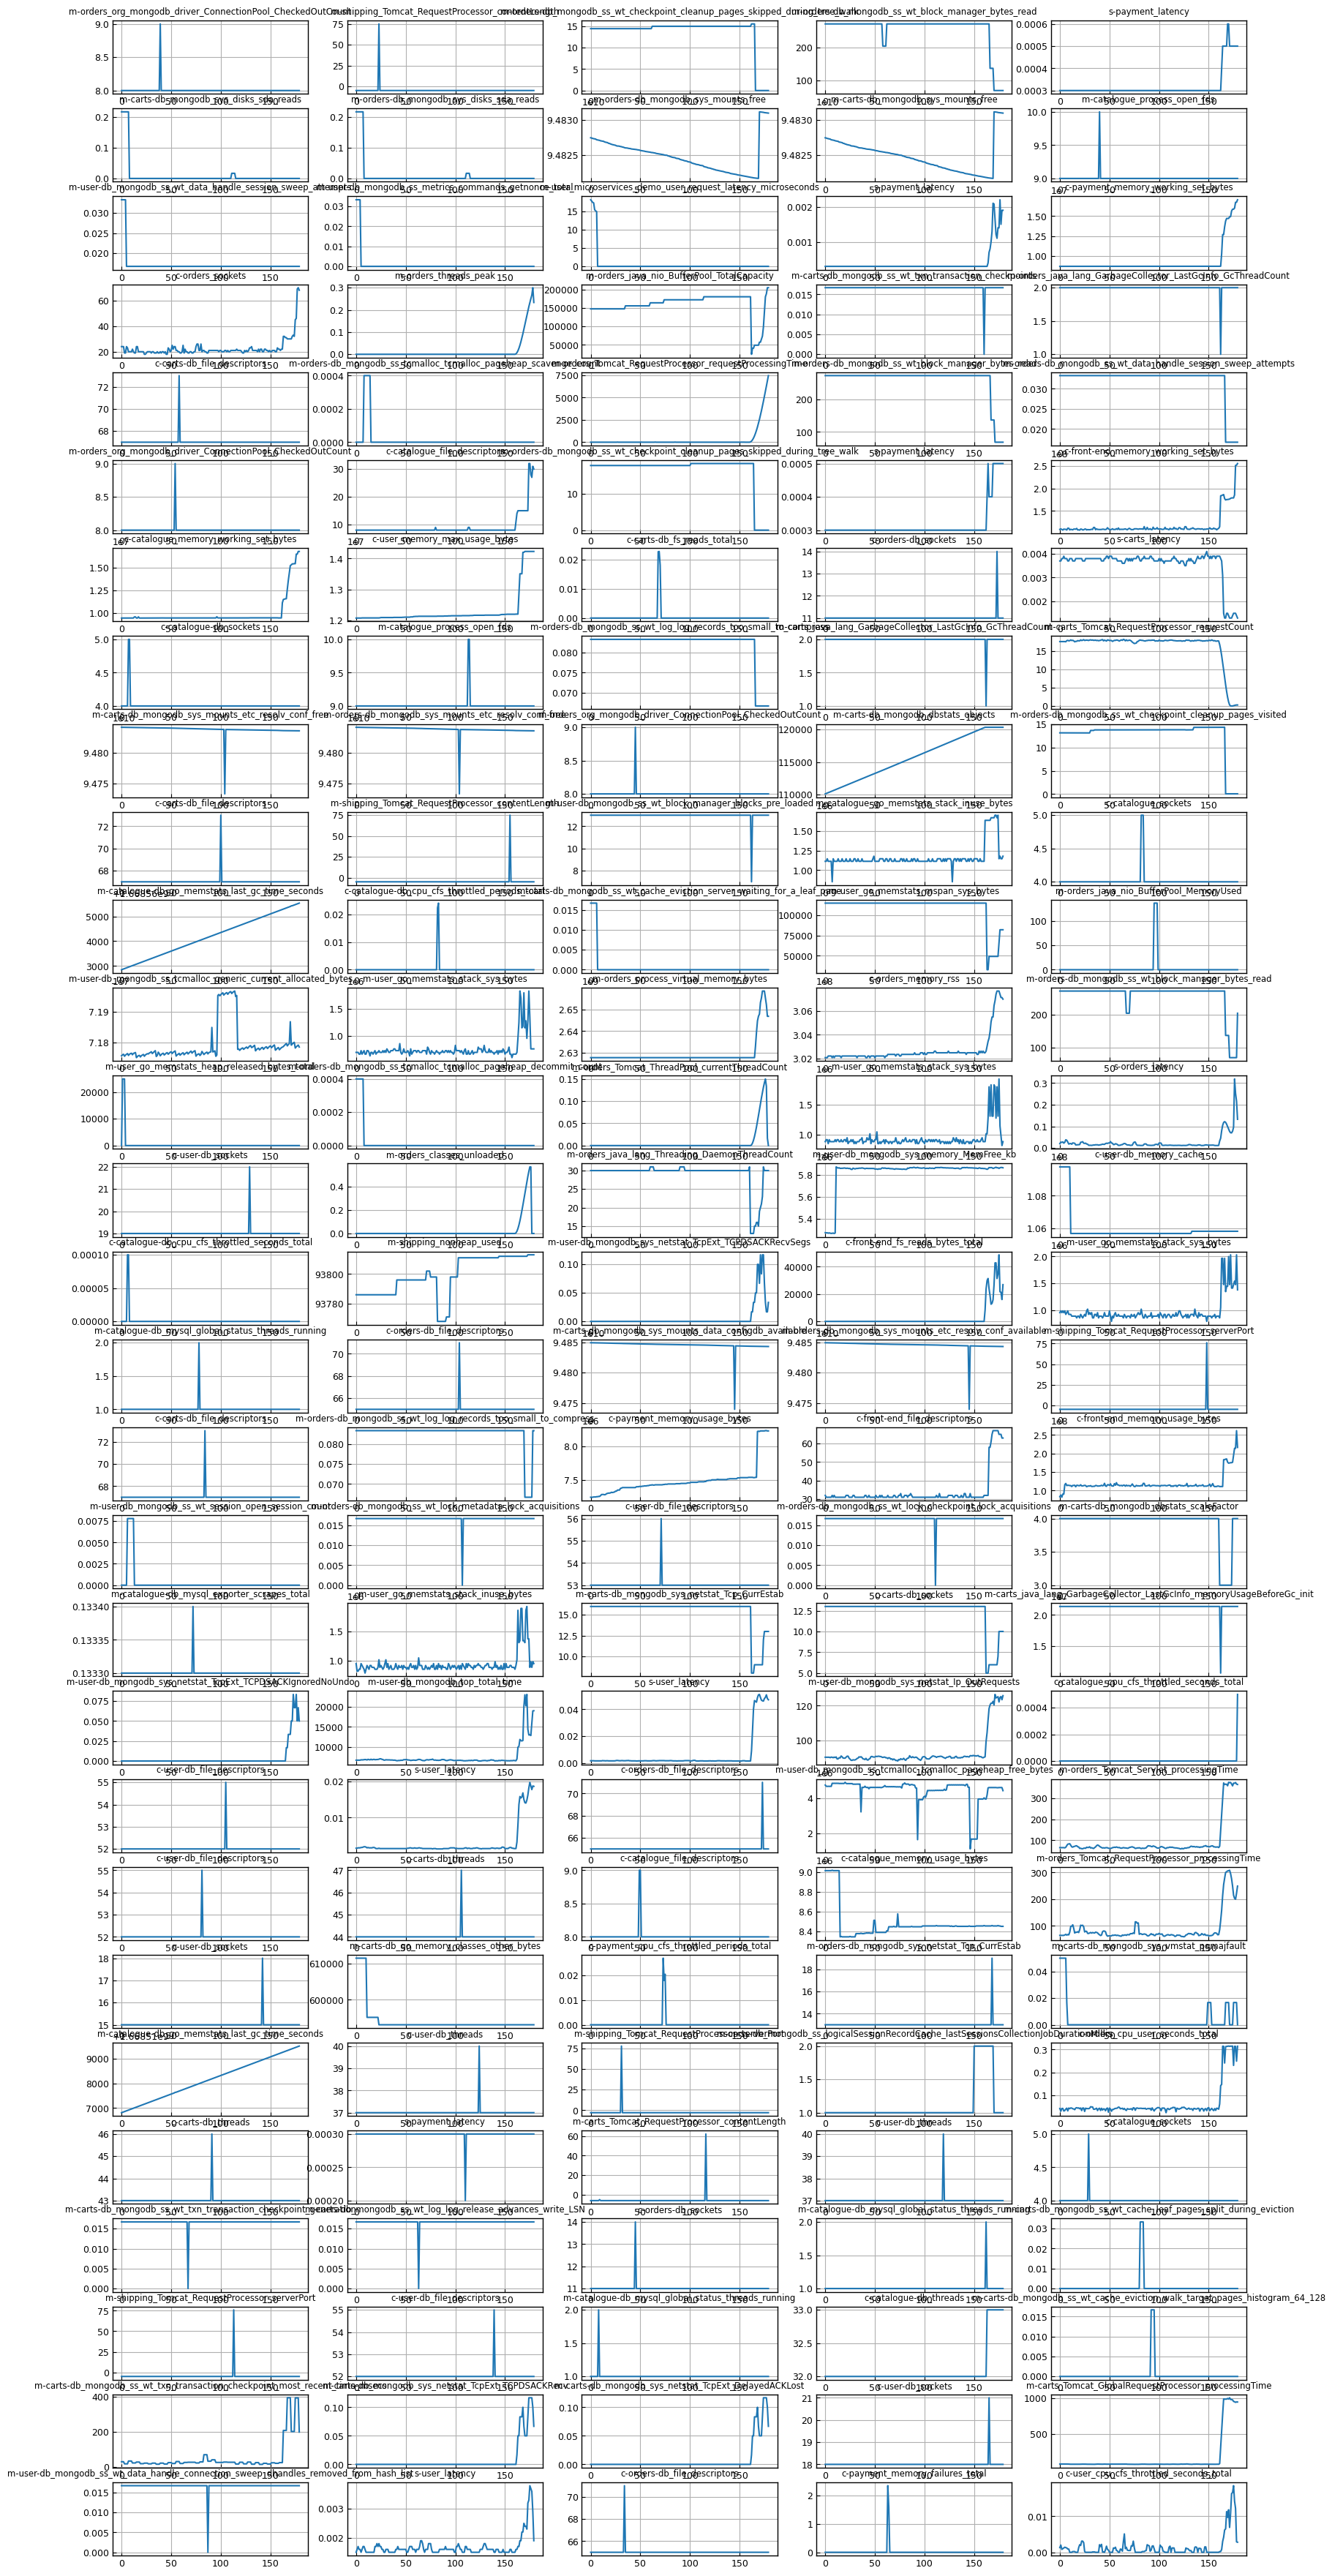

In [162]:
import math

_sorted_results_df = predicted_and_reduced_df.query("not metric.str.startswith('n-')", engine='python').dropna(subset=["rank_score"]).sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank_score"], ascending=False).groupby(group_keys).head(n=5).set_index(group_keys)

fig = plt.figure(figsize=(20, 45))
axs = fig.subplots(nrows=math.ceil(_sorted_results_df.shape[0] / 5), ncols=5)
for ax, row in zip(axs.flatten(), _sorted_results_df.itertuples()):
    ax.plot(row.time_series)
    ax.set_title(row.metric)

In [163]:
from meltria.priorknowledge.priorknowledge import SockShopKnowledge
from diagnoser.metric_node import MetricNodes, MetricNode

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [168]:
from itertools import chain

from pandas.core.groupby import DataFrameGroupBy

from eval.groundtruth import check_cause_metrics

EXCLUDED_CAUSE_METRICS: list[str] = [
    "go_memstats"
]

n_faults = len(sorted_results_df)

def get_ranks_by_case(sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, granularity: str = "metric"):
    ranks_by_case: dict[str, dict[str, list[int]]] = defaultdict(lambda: defaultdict(list))
    n_cases: int = 0
    for (dataset_id, target_app, chaos_type, chaos_comp), group in sorted_results_df:
        if chaos_comp == "queue-master":
            continue
        metrics = [m for m in group["metric"].values.tolist() if not any([m.startswith(em) for em in EXCLUDED_CAUSE_METRICS])]
        ranks: list[int]
        match granularity:
            case "metric":
                ok, cause_metrics = check_cause_metrics(
                    pk, metrics, chaos_type=chaos_type, chaos_comp=chaos_comp, optional_cause=True,
                )
                if not ok or len(cause_metrics) == 0:
                    print(f"no cause metrics: {dataset_id}, {target_app}, {chaos_type}, {chaos_comp}")
                    continue
                ranked_metrics = MetricNodes.from_metric_names(metrics)
                ranks = sorted([list(ranked_metrics).index(cm) + 1 for cm in cause_metrics])
            case "container":
                ranked_ctnrs = dict.fromkeys([pk.get_container_by_metric(metric) for metric in metrics])
                ranks = sorted([i+1 for i, ctnr in enumerate(ranked_ctnrs) if ctnr == chaos_comp])
            case "service":
                chaos_service: str = pk.get_service_by_container(chaos_comp)
                ranked_service = dict.fromkeys([pk.get_service_by_metric(metric) for metric in metrics])
                ranked_service = [s for s in ranked_service if not s.startswith("gke-")]
                ranks = sorted([i+1 for i, service in enumerate(ranked_service) if service == chaos_service])
            case _:
                assert False, f"Unknown detect_unit: {granularity}"
        ranks_by_case[chaos_type][chaos_comp] = ranks
        n_cases += 1
    return ranks_by_case, n_cases


def calc_ac_k(k: int, ranks_by_case: dict[str, dict[str, list[int]]], n_faults: int) -> float:
    ac_a: list[float] = []
    sum_ac = 0.0
    for chaos_type, ranks_by_ in ranks_by_case.items():
        for chaos_comp, ranks in ranks_by_.items():
            if (min_param := min(k, len(ranks)) > 0):
                sum_ac += sum([1 if ranks[i-1] <= k else 0 for i in range(1, min_param+1)]) / min_param
    return sum_ac / n_faults


def evaluate_ac_of_rc(
    sorted_results_df: DataFrameGroupBy, pk: SockShopKnowledge, k: int = 10, granuallity: str = "metric",
) -> pd.DataFrame:
    top_k_set = range(1, k+1)
    ranks_by_case, n_cases = get_ranks_by_case(sorted_results_df, pk, granularity=granuallity)
    ac_k = {k: calc_ac_k(k, ranks_by_case, n_cases) for k in top_k_set}
    avg_k = {k: sum([ac_k[j] for j in range(1, k+1)]) / k for k in top_k_set}
    return pd.concat([pd.DataFrame(ac_k, index=[f"AC@K ({granuallity})"]).T, pd.DataFrame(avg_k, index=[f"AVG@K ({granuallity})"]).T], axis=1)

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(sorted_results_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-cpu-hog, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, carts
no cause metrics: qknmc, sock-shop, pod-network-loss, carts-db
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue-db
no cause metrics: qknmc, sock-shop, pod-network-loss, orders-db
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user
no cause metrics: qknmc, sock-shop, pod-network-loss, user-db


,AC@K (metric),AVG@K (metric),AC@K (container),AVG@K (container),AC@K (service),AVG@K (service)
1,0.00,0.00,0.14,0.14,0.24,0.24
2,0.10,0.05,0.21,0.17,0.41,0.33
3,0.15,0.08,0.38,0.24,0.66,0.44
4,0.15,0.10,0.52,0.31,0.79,0.53
5,0.25,0.13,0.59,0.37,0.83,0.59
6,0.30,0.16,0.72,0.43,0.97,0.65
7,0.40,0.19,0.76,0.47,1.00,0.70
8,0.45,0.23,0.79,0.51,1.00,0.74
9,0.55,0.26,0.83,0.55,1.00,0.77
10,0.60,0.30,0.86,0.58,1.00,0.79


In [165]:
kstest_only_df = predicted_df_after_ks_test.query("not metric.str.startswith('n-')").sort_values(["dataset_id", "target_app", "chaos_type", "chaos_comp", "rank_score"], ascending=False).groupby(group_keys)

with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None, "display.precision", 2):
    display(
        pd.concat([
            evaluate_ac_of_rc(kstest_only_df, pk, k=10, granuallity="metric"),
            evaluate_ac_of_rc(kstest_only_df, pk, k=10, granuallity="container"),
            evaluate_ac_of_rc(kstest_only_df, pk, k=10, granuallity="service"),
        ], axis=1)
    )

no cause metrics: qknmc, sock-shop, pod-cpu-hog, catalogue
no cause metrics: qknmc, sock-shop, pod-memory-hog, catalogue-db
no cause metrics: qknmc, sock-shop, pod-memory-hog, front-end
no cause metrics: qknmc, sock-shop, pod-memory-hog, user
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue
no cause metrics: qknmc, sock-shop, pod-network-loss, catalogue-db
no cause metrics: qknmc, sock-shop, pod-network-loss, payment
no cause metrics: qknmc, sock-shop, pod-network-loss, user


,AC@K (metric),AVG@K (metric),AC@K (container),AVG@K (container),AC@K (service),AVG@K (service)
1,0.05,0.05,0.10,0.10,0.21,0.21
2,0.05,0.05,0.21,0.16,0.45,0.33
3,0.05,0.05,0.34,0.22,0.66,0.44
4,0.10,0.06,0.52,0.29,0.76,0.52
5,0.10,0.07,0.59,0.35,0.93,0.60
6,0.14,0.08,0.76,0.42,0.93,0.66
7,0.14,0.09,0.79,0.47,1.00,0.70
8,0.14,0.10,0.86,0.52,1.00,0.74
9,0.19,0.11,0.93,0.57,1.00,0.77
10,0.19,0.11,0.97,0.61,1.00,0.79
